# Dynamical Power Spectra (on fake data)

In [1]:
%matplotlib inline

In [2]:
# import some modules
import numpy as np
import matplotlib.pyplot as plt
import stingray
stingray.__version__

'2.2.dev64+ga4a8b8a0'

In [3]:
# choose style of plots, `seaborn-v0_8-talk` produce nice big figures
plt.style.use('seaborn-v0_8-talk')

## Generate a fake lightcurve

In [4]:
# Array of timestamps, 10000 bins from 1s to 100s
times = np.linspace(1,100,10000)

# base component of the lightcurve, poisson-like
# the averaged count-rate is 100 counts/bin
noise = np.random.poisson(100,10000)

# time evolution of the frequency of our fake periodic signal
# the frequency changes with a sinusoidal shape around the value 24Hz
freq = 25 + 1.2*np.sin(2*np.pi*times/130)

# Our fake periodic variability with drifting frequency
# the amplitude of this variability is 10% of the base flux
var = 10*np.sin(2*np.pi*freq*times)

# The signal of our lightcurve is equal the base flux plus the variable flux
signal = noise+var

In [5]:
# Create the lightcurve object
lc = stingray.Lightcurve(times, signal)

### Visualizing the lightcurve

<AxesSubplot: title={'center': 'Lightcurve'}, xlabel='Time (s)', ylabel='Counts / bin'>

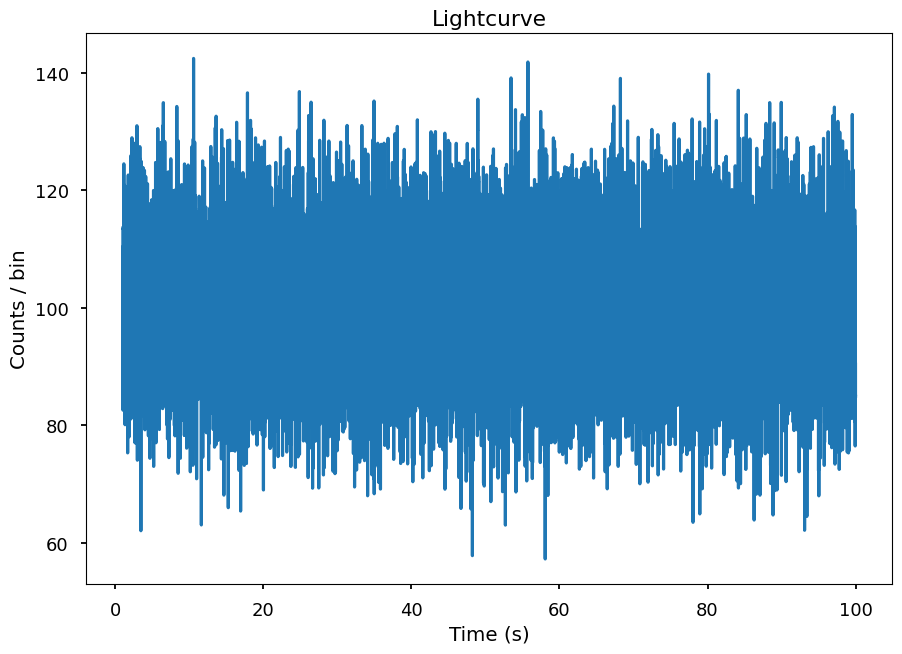

In [6]:
lc.plot(labels=['Time (s)', 'Counts / bin'], title="Lightcurve")

### Zomming in..

<AxesSubplot: title={'center': 'Zoomed in Lightcurve'}, xlabel='Time (s)', ylabel='Counts / bin'>

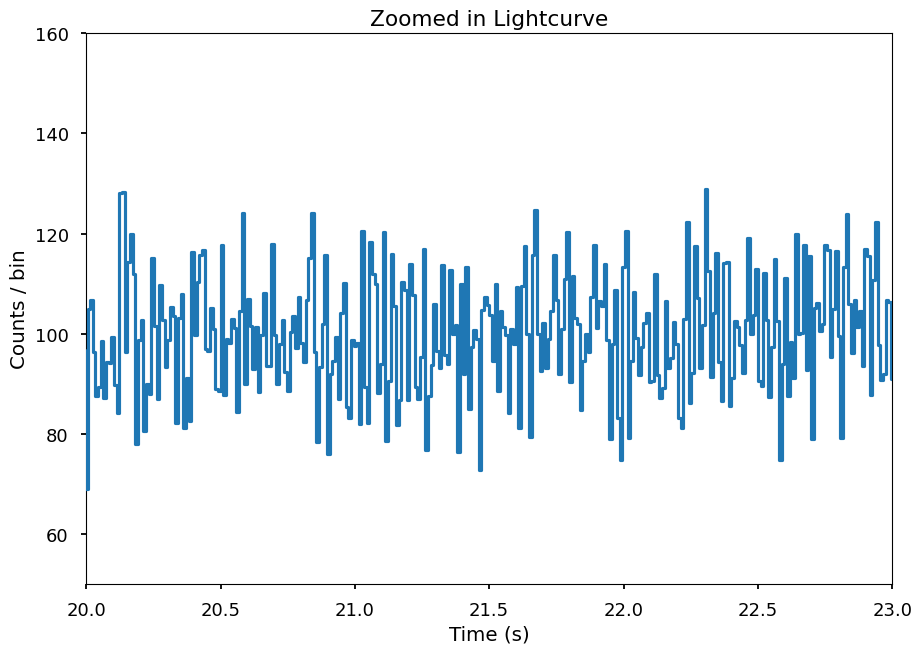

In [7]:
lc.plot(labels=['Time (s)', 'Counts / bin'], axis=[20,23,50,160], title='Zoomed in Lightcurve')

# A power spectrum of this lightcurve..

In [8]:
ps = stingray.AveragedPowerspectrum(lc, segment_size=3, norm='leahy')

33it [00:00, 13361.52it/s]


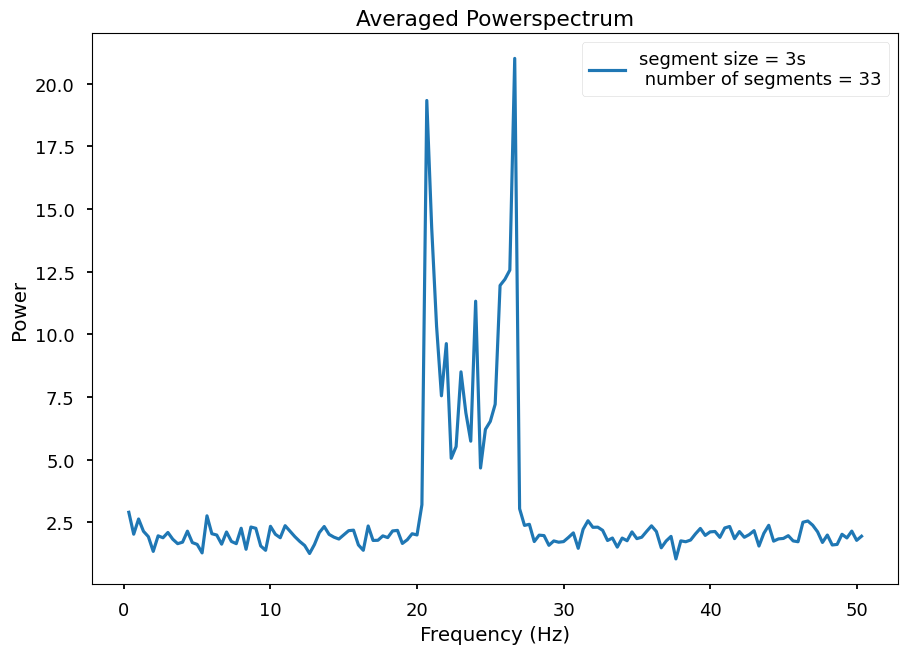

In [9]:
plt.plot(ps.freq, ps.power, label='segment size = {}s \n number of segments = {}'.format(3, int(lc.tseg/3)))
plt.title('Averaged Powerspectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

## It looks like we have at least 2 frequencies. 
# Let's look at the Dynamic Powerspectrum..

In [10]:
dps = stingray.DynamicalPowerspectrum(lc, segment_size=3, norm="leahy")

33it [00:00, 4274.61it/s]


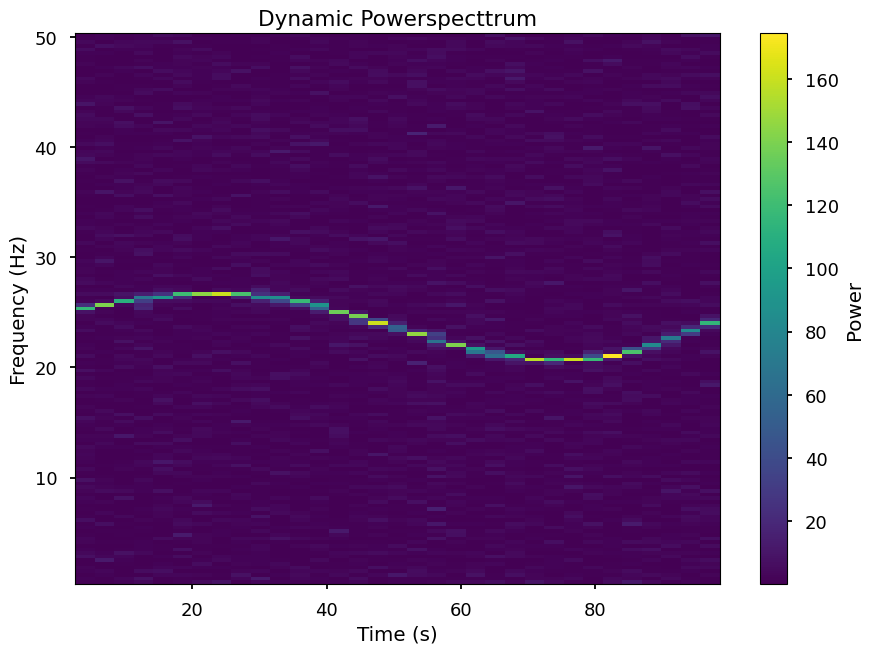

In [11]:
extent = min(dps.time), max(dps.time), min(dps.freq), max(dps.freq)
plt.imshow(dps.dyn_ps, aspect="auto", origin="lower",
           interpolation="none", extent=extent)
plt.title('Dynamic Powerspecttrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power')

## It is actually only one feature drifiting along time

 # Rebinning in Frequency

In [12]:
print("The current frequency resolution is {}".format(dps.df))

The current frequency resolution is 0.33333333333324333


Let's rebin to a frequency resolution of 1 Hz and using the average of the power

In [13]:
dps_new_f = dps.rebin_frequency(df_new=1.0, method="average")

In [14]:
print("The new frequency resolution is {}".format(dps_new_f.df))

The new frequency resolution is 1.0


Let's see how the Dynamical Powerspectrum looks now

(15.0, 30.0)

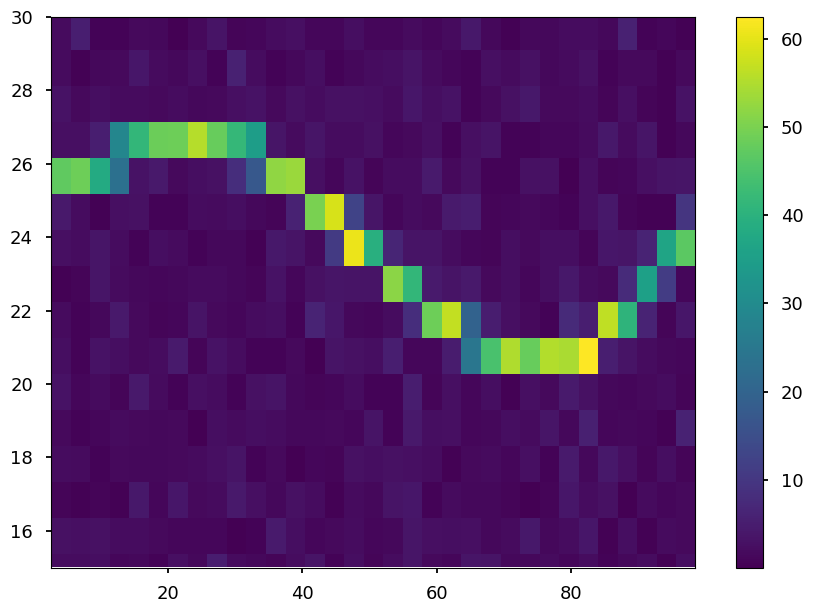

In [15]:
extent = min(dps_new_f.time), max(dps_new_f.time), min(dps_new_f.freq), max(dps_new_f.freq)
plt.imshow(dps_new_f.dyn_ps, origin="lower", aspect="auto",
           interpolation="none", extent=extent)
plt.colorbar()
plt.ylim(15, 30)

# Rebin time

Let's  rebin our matrix in the time axis

In [16]:
print("The current time resolution is {}".format(dps.dt))

The current time resolution is 3


Let's rebin to a time resolution of 4 s

In [17]:
dps_new_t = dps.rebin_time(dt_new=6.0, method="average")

In [18]:
print("The new time resolution is {}".format(dps_new_t.dt))

The new time resolution is 6.0


(15.0, 30.0)

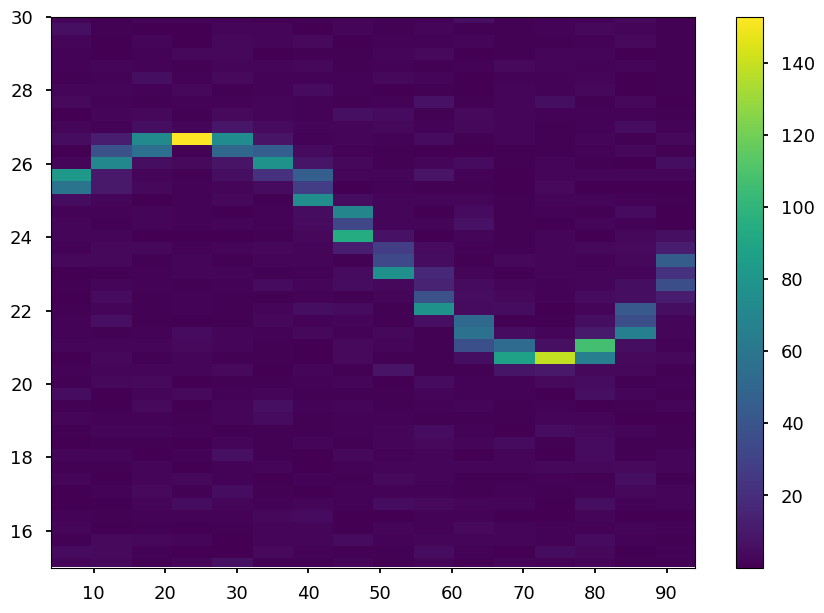

In [19]:
extent = min(dps_new_t.time), max(dps_new_t.time), min(dps_new_t.freq), max(dps_new_t.freq)
plt.imshow(dps_new_t.dyn_ps, origin="lower", aspect="auto",
           interpolation="none", extent=extent)
plt.colorbar()
plt.ylim(15,30)

## Let's trace that drifiting feature.

In [20]:
# By looking into the maximum power of each segment
max_pos = dps.trace_maximum()

Text(0.5, 1.0, 'Detected frequency drift')

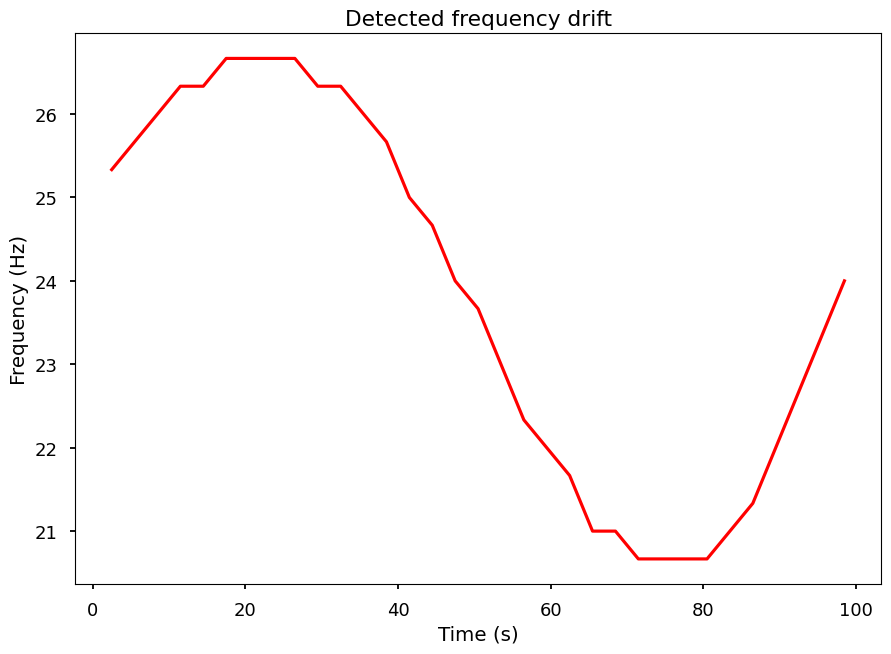

In [21]:
plt.plot(dps.time, dps.freq[max_pos], color='red', alpha=1)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Detected frequency drift')

# Overlaying this traced function with the Dynamical Powerspectrum

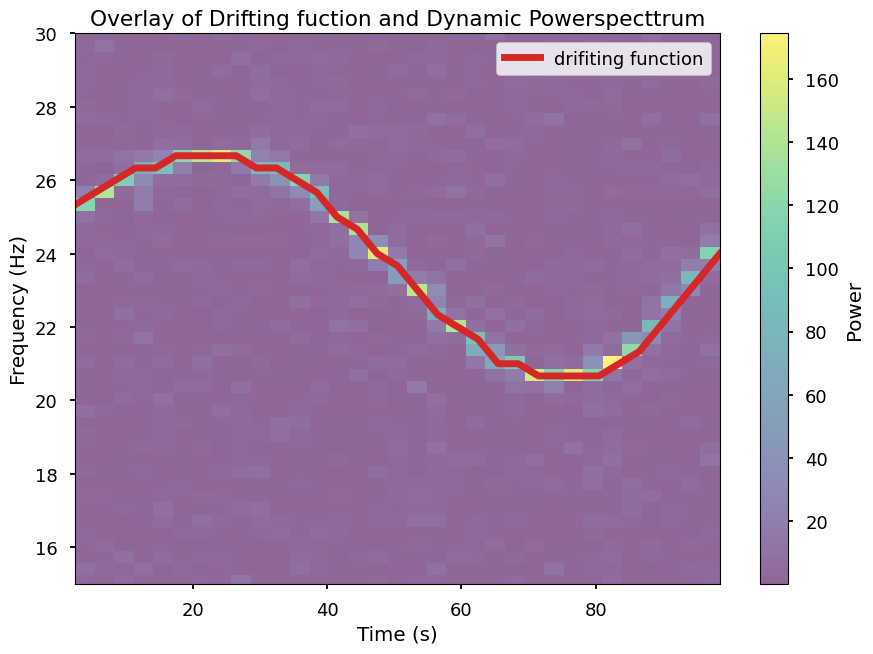

In [22]:
extent = min(dps.time), max(dps.time), min(dps.freq), max(dps.freq)
plt.imshow(dps.dyn_ps, aspect="auto", origin="lower",
           interpolation="none", extent=extent, alpha=0.6)
plt.plot(dps.time, dps.freq[max_pos], color='C3', lw=5, alpha=1, label='drifiting function')

plt.ylim(15,30) # zoom-in around 24 hertz

plt.title('Overlay of Drifting fuction and Dynamic Powerspecttrum')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power')
plt.legend()

# Shifting-and-adding

Shift-and-add is a technique used to improve the detection of QPOs ([Méndez et al. 1998](https://doi.org/10.1086/311600)). Basically, the spectrum is calculated in many segments, just as in the dynamical power spectrum above, but then the single spectra are shifted so that they are centered in the variable frequency of the followed feature. 
This technique is implemented in Stingray's Dynamic Cross- and Powerspectrum. We can apply it here, using the `trace_maximum` functionality from the sections above.


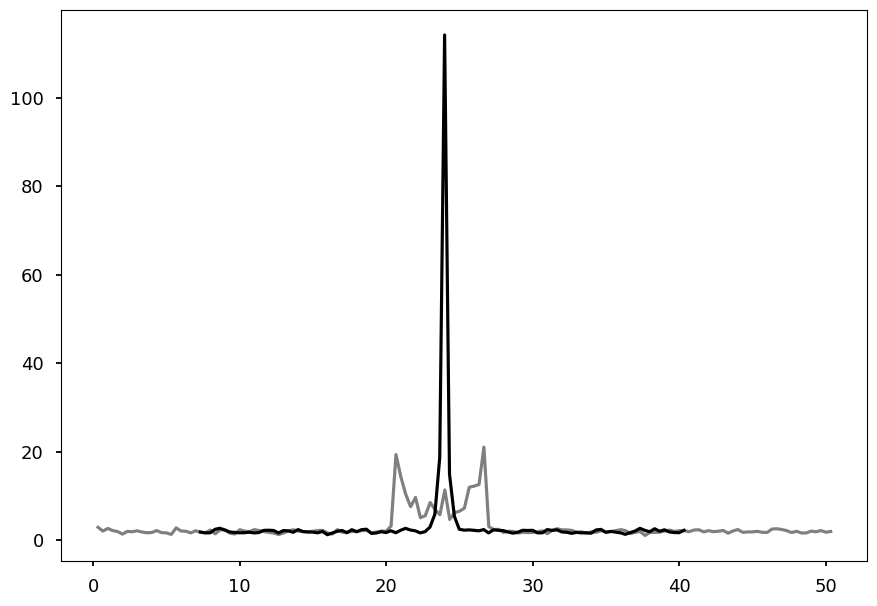

In [25]:
max_pos = dps.trace_maximum()
f0_list = dps.freq[max_pos]

new_spec = dps.shift_and_add(f0_list, nbins=100)

# Let's compare it to the original power spectrum.
plt.plot(ps.freq, ps.power, label='power spectrum', alpha=0.5, color="k")
plt.plot(new_spec.freq, new_spec.power, label='Shifted-and-added', color="k")
